# Семинар 5: вопросно-ответные системы

Рассмотрим задачу извлечения ответа на вопрос на примере датасета SQuAD и модели DistilBert.

[Источник семинара](https://huggingface.co/docs/transformers/tasks/question_answering)

In [1]:
# !pip install datasets transformers deeppavlov

In [3]:
import collections
import random

import numpy as np
import pandas as pd
import transformers
from datasets import ClassLabel, Sequence, load_dataset, load_metric
from IPython.display import HTML, display
from tqdm.auto import tqdm
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

In [ ]:
from transformers import DPRReader, DPRReaderTokenizer

## Fine-tuning a model on a question-answering task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) model to a question answering task, which is the task of extracting the answer to a question from a given context. We will see how to easily load a dataset for these kinds of tasks and use the `Trainer` API to fine-tune a model on it.

[Widget inference representing the QA task](images/question_answering.png)

**Note:** This notebook finetunes models that answer question by taking a substring of a context, not by generating new text.

This notebook is built to run on any question answering task with the same format as SQUAD (version 1 or 2), with any model checkpoint from the [Model Hub](https://huggingface.co/models) as long as that model has a version with a token classification head and a fast tokenizer (check on [this table](https://huggingface.co/transformers/index.html#bigtable) if this is the case). It might just need some small adjustments if you decide to use a different dataset than the one used here. Depending on you model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those three parameters, then the rest of the notebook should run smoothly:

In [4]:
# This flag is the difference between SQUAD v1 or 2 (if you're using another dataset, it indicates if impossible
# answers are allowed or not).
squad_v2 = True
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.

For our example here, we'll use the [SQUAD dataset](https://rajpurkar.github.io/SQuAD-explorer/). The notebook should work with any question answering dataset provided by the 🤗 Datasets library. If you're using your own dataset defined from a JSON or csv file (see the [Datasets documentation](https://huggingface.co/docs/datasets/loading_datasets.html#from-local-files) on how to load them), it might need some adjustments in the names of the columns used.

In [5]:
datasets = load_dataset("squad_v2" if squad_v2 else "squad")

Found cached dataset squad_v2 (/home/ubuntu/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

We can see the training, validation and test sets all have a column for the context, the question and the answers to those questions.

To access an actual element, you need to select a split first, then give an index:

In [7]:
datasets["train"][0]

{'id': '56be85543aeaaa14008c9063',
 'title': 'Beyoncé',
 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'question': 'When did Beyonce start becoming popular?',
 'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}}

In [8]:
datasets["train"] = datasets["train"].shard(num_shards=10, index=0)
datasets["validation"] = datasets["validation"].shard(num_shards=10, index=0)

In [9]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 13032
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1188
    })
})

In [10]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(
        dataset
    ), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset) - 1)
        while pick in picks:
            pick = random.randint(0, len(dataset) - 1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(
                lambda x: [typ.feature.names[i] for i in x]
            )
    display(HTML(df.to_html()))

We can see the answers are indicated by their start position in the text (here at character 515) and their full text, which is a substring of the context as we mentioned above.

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset (automatically decoding the labels in passing).

The `datasets` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set.

In [11]:
show_random_elements(datasets["train"])

,id,title,context,question,answers
0,570ce94dfed7b91900d45ad0,Gymnastics,"A higher flight phase results in a higher vertical ground reaction force. Vertical ground reaction force represents external force which the gymnasts have to overcome with their muscle force and has an impact on the gymnasts linear and angular momentum. Another important variable that affects linear and angular momentum is time the landing takes Gymnasts can alter the shape of the area by increasing the time taken to perform the landing. Gymnasts can achieve this by increasing hip, knee and ankle amplitude. With the increase of height, the amplitude in ankles knees and hips rise the bars.",What is vertical ground reaction force?,"{'text': ['s external force which the gymnasts have to overcome with their muscle force and has an impact on the gymnasts linear and angular momentum'], 'answer_start': [114]}"
1,5733651b4776f419006609c2,Financial_crisis_of_2007%E2%80%9308,"Market strategist Phil Dow believes distinctions exist ""between the current market malaise"" and the Great Depression. He says the Dow Jones average's fall of more than 50% over a period of 17 months is similar to a 54.7% fall in the Great Depression, followed by a total drop of 89% over the following 16 months. ""It's very troubling if you have a mirror image,"" said Dow. Floyd Norris, the chief financial correspondent of The New York Times, wrote in a blog entry in March 2009 that the decline has not been a mirror image of the Great Depression, explaining that although the decline amounts were nearly the same at the time, the rates of decline had started much faster in 2007, and that the past year had only ranked eighth among the worst recorded years of percentage drops in the Dow. The past two years ranked third, however.",Who was the chief financial correspondent of The New York Times in March 2009?,"{'text': ['Floyd Norris'], 'answer_start': [373]}"
2,572785ddf1498d1400e8fabc,Carnival,"Adults have a meringue battle at midnight at the historic Plaça de les Cols. In the mysterious sortida del Moixo Foguer (the outing of Little-Bird-Bonfire) accompanied by the Xerraire (jabberer) who insults the crowd. In the King's precession he and his concubines scandalize the town with their sexual behavior. A correfoc (fire run) or Devil's dance (Ball de diables, features dancing youth amid the sparks and explosions of the ritual crew of devils. Other items includes bed races in the streets, the debauched Nit dels Mascarots, Karaoke sausage roasts, xatonades, the children's party, Vidalet, the last night of revelry, Vidalot, the talking-dance of the Mismatched Couples (Ball de Malcasats) and the children's King Caramel whose massive belly, long nose and sausage-like hair hint at his insatiable appetites.",What sort of battle do the adults have at midnight?,"{'text': ['meringue'], 'answer_start': [14]}"
3,572b872c34ae481900deae6b,Zinc,"Zinc deficiency is crop plants' most common micronutrient deficiency; it is particularly common in high-pH soils. Zinc-deficient soil is cultivated in the cropland of about half of Turkey and India, a third of China, and most of Western Australia, and substantial responses to zinc fertilization have been reported in these areas. Plants that grow in soils that are zinc-deficient are more susceptible to disease. Zinc is primarily added to the soil through the weathering of rocks, but humans have added zinc through fossil fuel combustion, mine waste, phosphate fertilizers, pesticide (zinc phosphide), limestone, manure, sewage sludge, and particles from galvanized surfaces. Excess zinc is toxic to plants, although zinc toxicity is far less widespread.",Excess zinc has what effect on plants?,"{'text': ['toxic'], 'answer_start': [694]}"
4,56f6f7d73d8e2e1400e372fc,Classical_music,"Many instruments originated during the Renaissance; others were variations of, or improvements upon, instruments that had existed previously. Some have survived to the present day; others have disappe

## Preprocessing the training data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

The following assertion ensures that our tokenizer is a fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, and we will need some of the special features they have for our preprocessing.

You can check which type of models have a fast tokenizer available and which don't on the [big table of models](https://huggingface.co/transformers/index.html#bigtable).

You can directly call this tokenizer on two sentences (one for the answer, one for the context):

In [13]:
tokenizer("What is your name?", "My name is Sylvain.")

{'input_ids': [101, 2054, 2003, 2115, 2171, 1029, 102, 2026, 2171, 2003, 25353, 22144, 2378, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

Now one specific thing for the preprocessing in question answering is how to deal with very long documents. We usually truncate them in other tasks, when they are longer than the model maximum sentence length, but here, removing part of the the context might result in losing the answer we are looking for. To deal with this, we will allow one (long) example in our dataset to give several input features, each of length shorter than the maximum length of the model (or the one we set as a hyper-parameter). Also, just in case the answer lies at the point we split a long context, we allow some overlap between the features we generate controlled by the hyper-parameter `doc_stride`:

In [14]:
max_length = 384  # The maximum length of a feature (question and context)
doc_stride = 128  # The authorized overlap between two part of the context when splitting it is needed.

Let's find one long example in our dataset:

In [15]:
for i, example in enumerate(datasets["train"]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > 384:
        break
example = datasets["train"][i]

Without any truncation, we get the following length for the input IDs:

In [16]:
len(tokenizer(example["question"], example["context"])["input_ids"])

438

Now, if we just truncate, we will lose information (and possibly the answer to our question):

In [17]:
len(
    tokenizer(
        example["question"],
        example["context"],
        max_length=max_length,
        truncation="only_second",
    )["input_ids"]
)

384

Note that we never want to truncate the question, only the context, else the `only_second` truncation picked. Now, our tokenizer can automatically return us a list of features capped by a certain maximum length, with the overlap we talked above, we just have to tell it with `return_overflowing_tokens=True` and by passing the stride:

In [18]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride,
)

Now we don't have one list of `input_ids`, but several:

In [19]:
[len(x) for x in tokenized_example["input_ids"]]

[384, 194]

And if we decode them, we can see the overlap:

In [20]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

[CLS] who beat out beyonce for best female video? [SEP] on april 4, 2008, beyonce married jay z. she publicly revealed their marriage in a video montage at the listening party for her third studio album, i am... sasha fierce, in manhattan's sony club on october 22, 2008. i am... sasha fierce was released on november 18, 2008 in the united states. the album formally introduces beyonce's alter ego sasha fierce, conceived during the making of her 2003 single " crazy in love ", selling 482, 000 copies in its first week, debuting atop the billboard 200, and giving beyonce her third consecutive number - one album in the us. the album featured the number - one song " single ladies ( put a ring on it ) " and the top - five songs " if i were a boy " and " halo ". achieving the accomplishment of becoming her longest - running hot 100 single in her career, " halo "'s success in the us helped beyonce attain more top - ten singles on the list than any other woman during the 2000s. it also included 

Now this will give us some work to properly treat the answers: we need to find in which of those features the answer actually is, and where exactly in that feature. The models we will use require the start and end positions of these answers in the tokens, so we will also need to to map parts of the original context to some tokens. Thankfully, the tokenizer we're using can help us with that by returning an `offset_mapping`:

In [21]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride,
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 3), (4, 8), (9, 12), (13, 20), (21, 24), (25, 29), (30, 36), (37, 42), (43, 44), (0, 0), (0, 2), (3, 8), (9, 10), (10, 11), (12, 16), (16, 17), (18, 25), (26, 33), (34, 37), (38, 39), (39, 40), (41, 44), (45, 53), (54, 62), (63, 68), (69, 77), (78, 80), (81, 82), (83, 88), (89, 93), (93, 96), (97, 99), (100, 103), (104, 113), (114, 119), (120, 123), (124, 127), (128, 133), (134, 140), (141, 146), (146, 147), (148, 149), (150, 152), (152, 153), (153, 154), (154, 155), (156, 161), (162, 168), (168, 169), (170, 172), (173, 182), (182, 183), (183, 184), (185, 189), (190, 194), (195, 197), (198, 205), (206, 208), (208, 209), (210, 214), (214, 215), (216, 217), (218, 220), (220, 221), (221, 222), (222, 223), (224, 229), (230, 236), (237, 240), (241, 249), (250, 252), (253, 261), (262, 264), (264, 265), (266, 270), (271, 273), (274, 277), (278, 284), (285, 291), (291, 292), (293, 296), (297, 302), (303, 311), (312, 322), (323, 330), (330, 331), (331, 332), (333, 338), (339, 342),

This gives, for each index of our input IDS, the corresponding start and end character in the original text that gave our token. The very first token (`[CLS]`) has (0, 0) because it doesn't correspond to any part of the question/answer, then the second token is the same as the characters 0 to 3 of the question:

In [22]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(
    tokenizer.convert_ids_to_tokens([first_token_id])[0],
    example["question"][offsets[0] : offsets[1]],
)

who Who


So we can use this mapping to find the position of the start and end tokens of our answer in a given feature. We just have to distinguish which parts of the offsets correspond to the question and which part correspond to the context, this is where the `sequence_ids` method of our `tokenized_example` can be useful:

In [23]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

It returns `None` for the special tokens, then 0 or 1 depending on whether the corresponding token comes from the first sentence past (the question) or the second (the context). Now with all of this, we can find the first and last token of the answer in one of our input feature (or if the answer is not in this feature):

In [24]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (
    offsets[token_start_index][0] <= start_char
    and offsets[token_end_index][1] >= end_char
):
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while (
        token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char
    ):
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("The answer is not in this feature.")

364 365


Reduce the size of dataset to faster model training:

And we can double check that it is indeed the theoretical answer:

In [25]:
print(
    tokenizer.decode(
        tokenized_example["input_ids"][0][start_position : end_position + 1]
    )
)
print(answers["text"][0])

taylor swift
Taylor Swift


For this notebook to work with any kind of models, we need to account for the special case where the model expects padding on the left (in which case we switch the order of the question and the context):

In [26]:
pad_on_right = tokenizer.padding_side == "right"

Now let's put everything together in one function we will apply to our training set. In the case of impossible answers (the answer is in another feature given by an example with a long context), we set the cls index for both the start and end position. We could also simply discard those examples from the training set if the flag `allow_impossible_answers` is `False`. Since the preprocessing is already complex enough as it is, we've kept is simple for this part.

In [27]:
def prepare_train_features(examples):
    print(examples)
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    print(sample_mapping)
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")
    print(offset_mapping)

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (
                offsets[token_start_index][0] <= start_char
                and offsets[token_end_index][1] >= end_char
            ):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while (
                    token_start_index < len(offsets)
                    and offsets[token_start_index][0] <= start_char
                ):
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [28]:
features = prepare_train_features(datasets["train"][:2])

{'id': ['56be85543aeaaa14008c9063', '56d43c5f2ccc5a1400d830ab'], 'title': ['Beyoncé', 'Beyoncé'], 'context': ['Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".', 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she pe

In [29]:
features

{'input_ids': [[101, 2043, 2106, 20773, 2707, 3352, 2759, 1029, 102, 20773, 21025, 19358, 22815, 1011, 5708, 1006, 1013, 12170, 23432, 29715, 3501, 29678, 12325, 29685, 1013, 10506, 1011, 10930, 2078, 1011, 2360, 1007, 1006, 2141, 2244, 1018, 1010, 3261, 1007, 2003, 2019, 2137, 3220, 1010, 6009, 1010, 2501, 3135, 1998, 3883, 1012, 2141, 1998, 2992, 1999, 5395, 1010, 3146, 1010, 2016, 2864, 1999, 2536, 4823, 1998, 5613, 6479, 2004, 1037, 2775, 1010, 1998, 3123, 2000, 4476, 1999, 1996, 2397, 4134, 2004, 2599, 3220, 1997, 1054, 1004, 1038, 2611, 1011, 2177, 10461, 1005, 1055, 2775, 1012, 3266, 2011, 2014, 2269, 1010, 25436, 22815, 1010, 1996, 2177, 2150, 2028, 1997, 1996, 2088, 1005, 1055, 2190, 1011, 4855, 2611, 2967, 1997, 2035, 2051, 1012, 2037, 14221, 2387, 1996, 2713, 1997, 20773, 1005, 1055, 2834, 2201, 1010, 20754, 1999, 2293, 1006, 2494, 1007, 1010, 2029, 2511, 2014, 2004, 1037, 3948, 3063, 4969, 1010, 3687, 2274, 8922, 2982, 1998, 2956, 1996, 4908, 2980, 2531, 2193, 1011, 2028, 3

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command. Since our preprocessing changes the number of samples, we need to remove the old columns when applying it.

In [30]:
tokenized_datasets = datasets.map(
    prepare_train_features, batched=True, remove_columns=datasets["train"].column_names
)

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d/cache-412f82e54d5ec7d0.arrow
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d/cache-c4b9e61e1db44a40.arrow


Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

## Fine-tuning the model

Now that our data is ready for training, we can download the pretrained model and fine-tune it. Since our task is question answering, we use the `AutoModelForQuestionAnswering` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us:

In [31]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

In [32]:
model

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            

The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define three more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [ ]:
from tranformers import Trainer, TrainingArguments, default_data_collator

In [33]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-squad",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=0.5,
    weight_decay=0.01,
    # push_to_hub=True,
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay.

The last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"sgugger/bert-finetuned-squad"` or `"huggingface/bert-finetuned-squad"`).

Then we will need a data collator that will batch our processed examples together, here the default one will work:

We will evaluate our model and compute metrics in the next section (this is a very long operation, so we will only compute the evaluation loss during training).

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [34]:
data_collator = default_data_collator

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

train_data_loader = trainer.get_train_dataloader()
next(iter(train_data_loader))

{'input_ids': tensor([[ 101, 2054, 2744,  ...,    0,    0,    0],
         [ 101, 2054, 2001,  ...,    0,    0,    0],
         [ 101, 2043, 2106,  ...,    0,    0,    0],
         ...,
         [ 101, 2040, 2106,  ...,    0,    0,    0],
         [ 101, 2054, 2515,  ...,    0,    0,    0],
         [ 101, 2054, 2515,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'start_positions': tensor([ 15,  65,  77,  83,   0,   0,  76, 113,  78,  48, 124,   0,  24,   0,
          61,  53]),
 'end_positions': tensor([ 15,  69,  81,  84,   0,   0,  85, 115,  78,  50, 126,   0,  24,   0,
          64,  56])}

We can now finetune our model by just calling the `train` method:

In [35]:
trainer.train()

/home/ubuntu/anaconda3/envs/ml/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 13174
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 412
  Number of trainable parameters = 66364418


Epoch,Training Loss,Validation Loss


***** Running Evaluation *****
  Num examples = 1214
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=412, training_loss=3.1919570478420813, metrics={'train_runtime': 83.3117, 'train_samples_per_second': 79.065, 'train_steps_per_second': 4.945, 'total_flos': 645948926558208.0, 'train_loss': 3.1919570478420813, 'epoch': 0.5})

Since this training is particularly long, let's save the model just in case we need to restart.

In [36]:
trainer.save_model("test-squad-trained")

Saving model checkpoint to test-squad-trained
Configuration saved in test-squad-trained/config.json
Model weights saved in test-squad-trained/pytorch_model.bin
tokenizer config file saved in test-squad-trained/tokenizer_config.json
Special tokens file saved in test-squad-trained/special_tokens_map.json


## Evaluation
Evaluating our model will require a bit more work, as we will need to map the predictions of our model back to parts of the context. The model itself predicts logits for the start and en position of our answers: if we take a batch from our validation datalaoder, here is the output our model gives us:

In [37]:
import torch

for batch in trainer.get_eval_dataloader():
    break
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

The output of the model is a dict-like object that contains the loss (since we provided labels), the start and end logits. We won't need the loss for our predictions, let's have a look a the logits:

In [38]:
output.start_logits.shape, output.end_logits.shape

(torch.Size([16, 384]), torch.Size([16, 384]))

In [39]:
output.start_logits[1]

tensor([ 5.0747e+00, -1.4125e+00, -2.4848e+00, -1.0763e+00, -1.0137e+00,
        -3.2957e+00, -1.5204e+00, -2.3846e+00, -9.6927e-01, -3.6401e-01,
        -2.6550e+00, -2.1038e+00, -4.6090e-01, -4.8356e-01, -1.7448e-01,
        -2.6611e+00, -7.0849e-01, -2.9883e+00, -1.9103e+00, -2.5498e+00,
        -2.3191e+00,  1.1270e+00, -1.8767e+00, -2.8956e+00, -1.3409e+00,
        -9.4813e-01,  3.5120e-01, -1.9085e+00, -2.7849e+00,  1.0616e+00,
        -9.4620e-02, -2.1967e+00, -2.4713e+00, -6.3183e-01, -2.2074e+00,
        -1.0270e+00,  1.1023e+00, -1.9609e+00, -2.4142e+00, -5.6187e-01,
        -2.0546e+00, -2.4475e-01,  1.8890e+00, -6.5393e-01, -1.9465e+00,
        -2.7660e+00, -1.1142e+00,  1.8422e-01, -2.2064e+00, -2.7790e+00,
        -2.4412e+00,  7.3406e-01,  1.6130e+00, -1.0287e+00, -2.3740e+00,
        -3.2069e+00, -1.8979e+00, -6.5520e-01, -2.4905e+00, -2.9679e+00,
        -3.4211e+00, -1.3539e+00, -1.5546e+00,  3.0582e-01,  2.5373e+00,
        -3.0257e+00, -1.3642e+00, -2.1056e+00, -2.8

We have one logit for each feature and each token. The most obvious thing to predict an answer for each featyre is to take the index for the maximum of the start logits as a start position and the index of the maximum of the end logits as an end position.

In [40]:
output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))

This will work great in a lot of cases, but what if this prediction gives us something impossible: the start position could be greater than the end position, or point to a span of text in the question instead of the answer. In that case, we might want to look at the second best prediction to see if it gives a possible answer and select that instead.

However, picking the second best answer is not as easy as picking the best one: is it the second best index in the start logits with the best index in the end logits? Or the best index in the start logits with the second best index in the end logits? And if that second best answer is not possible either, it gets even trickier for the third best answer.


To classify our answers, we will use the score obtained by adding the start and end logits. We won't try to order all the possible answers and limit ourselves to with a hyper-parameter we call `n_best_size`. We'll pick the best indices in the start and end logits and gather all the answers this predicts. After checking if each one is valid, we will sort them by their score and keep the best one. Here is how we would do this on the first feature in the batch:

In [41]:
n_best_size = 20

In [42]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if (
            start_index <= end_index
        ):  # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "",  # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

And then we can sort the `valid_answers` according to their `score` and only keep the best one. The only point left is how to check a given span is inside the context (and not the question) and how to get back the text inside. To do this, we need to add two things to our validation features:
- the ID of the example that generated the feature (since each example can generate several features, as seen before);
- the offset mapping that will give us a map from token indices to character positions in the context.

That's why we will re-process the validation set with the following function, slightly different from `prepare_train_features`:

In [43]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

And like before, we can apply that function to our validation set easily:

In [44]:
validation_features = datasets["validation"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["validation"].column_names,
)

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d/cache-b5c2f28fe4725ee3.arrow


Now we can grab the predictions for all features by using the `Trainer.predict` method:

In [45]:
raw_predictions = trainer.predict(validation_features)

The following columns in the test set don't have a corresponding argument in `DistilBertForQuestionAnswering.forward` and have been ignored: example_id, offset_mapping. If example_id, offset_mapping are not expected by `DistilBertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1214
  Batch size = 16


The `Trainer` *hides* the columns that are not used by the model (here `example_id` and `offset_mapping` which we will need for our post-processing), so we set them back:

In [46]:
validation_features.set_format(
    type=validation_features.format["type"],
    columns=list(validation_features.features.keys()),
)

We can now refine the test we had before: since we set `None` in the offset mappings when it corresponds to a part of the question, it's easy to check if an answer is fully inside the context. We also eliminate very long answers from our considerations (with an hyper-parameter we can tune)

In [47]:
max_answer_length = 30

In [48]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = datasets["validation"][0]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if (
            start_index <= end_index
        ):  # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char:end_char],
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[
    :n_best_size
]
valid_answers

[{'score': 7.86468, 'text': 'Latin: Normanni'},
 {'score': 7.4482374, 'text': 'Nourmands; French: Normands; Latin: Normanni'},
 {'score': 7.4292135, 'text': 'French: Normands; Latin: Normanni'},
 {'score': 7.2175903,
  'text': 'Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France'},
 {'score': 7.1508284, 'text': 'Normandy, a region in France'},
 {'score': 7.0592403,
  'text': 'Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy'},
 {'score': 6.9924784, 'text': 'Normandy'},
 {'score': 6.9757853, 'text': 'Norse'},
 {'score': 6.822949, 'text': 'Normands; Latin: Normanni'},
 {'score': 6.7821236,
  'text': 'French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France'},
 {'score': 6.7317686,
  'text': 'Normandy, a region in France. They were descended from Norse'},
 {'score': 6.6797624, 'text': 'Nourmands; French:

We can compare to the actual ground-truth answer:

In [49]:
datasets["validation"][0]["answers"]

{'text': ['France', 'France', 'France', 'France'],
 'answer_start': [159, 159, 159, 159]}

Our model picked the right as the most likely answer!

As we mentioned in the code above, this was easy on the first feature because we knew it comes from the first example. For the other features, we will need a map between examples and their corresponding features. Also, since one example can give several features, we will need to gather together all the answers in all the features generated by a given example, then pick the best one. The following code builds a map from example index to its corresponding features indices:

In [50]:
examples = datasets["validation"]
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

We're almost ready for our post-processing function. The last bit to deal with is the impossible answer (when `squad_v2 = True`). The code above only keeps answers that are inside the context, we need to also grab the score for the impossible answer (which has start and end indices corresponding to the index of the CLS token). When one example gives several features, we have to predict the impossible answer when all the features give a high score to the impossible answer (since one feature could predict the impossible answer just because the answer isn't in the part of the context it has access too), which is why the score of the impossible answer for one example is the *minimum* of the scores for the impossible answer in each feature generated by the example.

We then predict the impossible answer when that score is greater than the score of the best non-impossible answer. All combined together, this gives us this post-processing function:

In [51]:
def postprocess_qa_predictions(
    examples, features, raw_predictions, n_best_size=20, max_answer_length=30
):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(
        f"Post-processing {len(examples)} example predictions split into {len(features)} features."
    )

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None  # Only used if squad_v2 is True.
        valid_answers = []

        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(
                tokenizer.cls_token_id
            )
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[
                -1 : -n_best_size - 1 : -1
            ].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char:end_char],
                        }
                    )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[
                0
            ]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}

        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = (
                best_answer["text"] if best_answer["score"] > min_null_score else ""
            )
            predictions[example["id"]] = answer

    return predictions

And we can apply our post-processing function to our raw predictions:

In [52]:
final_predictions = postprocess_qa_predictions(
    datasets["validation"], validation_features, raw_predictions.predictions
)

Post-processing 1188 example predictions split into 1214 features.


  0%|          | 0/1188 [00:00<?, ?it/s]

Then we can load the metric from the datasets library.

In [53]:
metric = load_metric("squad_v2" if squad_v2 else "squad")

/tmp/ipykernel_11401/3256360914.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2" if squad_v2 else "squad")


Then we can call compute on it. We just need to format predictions and labels a bit as it expects a list of dictionaries and not one big dictionary. In the case of squad_v2, we also have to set a `no_answer_probability` argument (which we set to 0.0 here as we have already set the answer to empty if we picked it).

In [54]:
if squad_v2:
    formatted_predictions = [
        {"id": k, "prediction_text": v, "no_answer_probability": 0.0}
        for k, v in final_predictions.items()
    ]
else:
    formatted_predictions = [
        {"id": k, "prediction_text": v} for k, v in final_predictions.items()
    ]
references = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]
]
metric.compute(predictions=formatted_predictions, references=references)

{'exact': 46.2962962962963,
 'f1': 46.2962962962963,
 'total': 1188,
 'HasAns_exact': 0.0,
 'HasAns_f1': 0.0,
 'HasAns_total': 638,
 'NoAns_exact': 100.0,
 'NoAns_f1': 100.0,
 'NoAns_total': 550,
 'best_exact': 46.2962962962963,
 'best_exact_thresh': 0.0,
 'best_f1': 46.2962962962963,
 'best_f1_thresh': 0.0}

### DPR

Рассмотрим примеры применения предобученной модели [DPR](https://huggingface.co/transformers/model_doc/dpr.html) (Dense Passage Retrieval). DPR использует два независимых кодировщика на основе BERT для получения представлений абзацев и вопросов, а затем вычисляет меру близости между полученными векторами. В huggingface представлена модель, предобученная на корпусе NQ (Natural Questions).

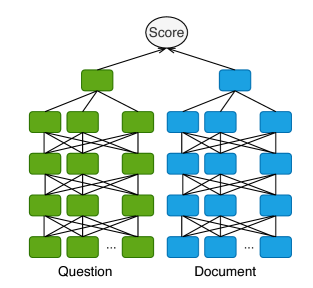

Инициализируем модель и токенизатор, закодируем вопрос и абзац, в котором будем искать ответ.

In [55]:
tokenizer = DPRReaderTokenizer.from_pretrained("facebook/dpr-reader-single-nq-base")
model = DPRReader.from_pretrained("facebook/dpr-reader-single-nq-base")
encoded_inputs = tokenizer(
    questions=["What is love ?"],
    titles=["Haddaway"],
    texts=["'What Is Love' is a song recorded by the artist Haddaway"],
    return_tensors="pt",
)

loading file vocab.txt from cache at /home/ubuntu/.cache/huggingface/hub/models--facebook--dpr-reader-single-nq-base/snapshots/38f47a4986084c53447ba92ab0a83076b58d86a8/vocab.txt
loading file tokenizer.json from cache at /home/ubuntu/.cache/huggingface/hub/models--facebook--dpr-reader-single-nq-base/snapshots/38f47a4986084c53447ba92ab0a83076b58d86a8/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/ubuntu/.cache/huggingface/hub/models--facebook--dpr-reader-single-nq-base/snapshots/38f47a4986084c53447ba92ab0a83076b58d86a8/tokenizer_config.json
loading configuration file config.json from cache at /home/ubuntu/.cache/huggingface/hub/models--facebook--dpr-reader-single-nq-base/snapshots/38f47a4986084c53447ba92ab0a83076b58d86a8/config.json
Model config DPRConfig {
  "_name_or_path": "facebook/dpr-reader-single-nq-base",
  "architectures": [
    "DPRReader"
  ],
  "att

Подадим на вход модели полученные представления, на выходе модели для каждого токена получим оценки того, что данный токен является началом ответа или концом ответа, а также степени релевантности заданного вопроса к ответу.

In [56]:
outputs = model(**encoded_inputs)
print(outputs)

start_logits = outputs.start_logits
end_logits = outputs.end_logits
relevance_logits = outputs.relevance_logits
print(relevance_logits)

DPRReaderOutput(start_logits=tensor([[-10.8401, -10.9547, -11.6122, -11.7393, -11.8875, -10.1823, -10.5815,
         -11.8506, -12.0426, -10.1807, -10.9000,  -7.6596, -10.6696, -10.0901,
         -11.6139,  -8.7515,  -2.9133,  -8.7516,  -9.2080, -10.6715,  -7.7011,
          -8.0729,  -3.9033,  -9.9640,  -8.8817]], grad_fn=<ViewBackward0>), end_logits=tensor([[-10.4685, -11.6659, -11.3631, -10.3586, -10.7090,  -6.9298, -11.8787,
         -11.3003, -10.1152,  -6.9275, -11.8452, -11.3403, -11.4762,  -8.2958,
         -11.0709, -11.7554, -10.3399,  -6.8261, -10.5824,  -9.6945,  -8.1308,
          -7.1005,  -8.0756, -10.2902,  -7.1413]], grad_fn=<ViewBackward0>), relevance_logits=tensor([-1.2456], grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)
tensor([-1.2456], grad_fn=<ViewBackward0>)


Получим индексы токенов с наиболее вероятными значениями начала и конца вопроса:

In [57]:
answer_start = torch.argmax(
    start_logits
)  # Get the most likely beginning of answer with the argmax of the score
answer_end = (
    torch.argmax(end_logits) + 1
)  # Get the most likely end of answer with the argmax of the score

Сформируем итоговый ответ в виде стороки:

In [58]:
answer = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(
        encoded_inputs["input_ids"][0][answer_start:answer_end]
    )
)

# print(f"Question: {question}")
print(f"Answer: {answer}\n")

Answer: a song



Рассмотрим пример с несколькими вопросами для одного абзаца, для этого в модель нужно передать список вопросов, пассажей и заголовков:

In [59]:
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""

questions = [
    "How many pretrained models are available in Transformers?",
    "What does Transformers provide?",
    "Transformers provides interoperability between which frameworks?",
]

title = "Transformers"

encoded_inputs = tokenizer(
    questions=questions,
    titles=[title] * 3,
    texts=[text] * 3,
    return_tensors="pt",
    truncation=True,
    padding=True,
)
outputs = model(**encoded_inputs)
answer_start_scores = outputs["start_logits"]
answer_end_scores = outputs["end_logits"]

answer_starts = torch.argmax(
    answer_start_scores, dim=1
)  # Get the most likely beginning of answer with the argmax of the score
answer_ends = (
    torch.argmax(answer_end_scores, dim=1) + 1
)  # Get the most likely end of answer with the argmax of the score

answers = [
    tokenizer.convert_tokens_to_string(
        tokenizer.convert_ids_to_tokens(
            encoded_inputs["input_ids"][0][answer_start:answer_end]
        )
    )
    for answer_start, answer_end in zip(answer_starts, answer_ends)
]

for question, answer in zip(questions, answers):
    print(f"Question: {question}")
    print(f"Answer: {answer}\n")

Question: How many pretrained models are available in Transformers?
Answer: over 32 +

Question: What does Transformers provide?
Answer: ##trained - bert )

Question: Transformers provides interoperability between which frameworks?
Answer: provides general - purpose architecture



### Deeppavlov and SberQUAD

[Источник](https://medium.com/deeppavlov/developing-qa-systems-for-any-language-with-deeppavlov-a9033d5231a8)

In [60]:
from deeppavlov import build_model, configs

In [61]:
model_qa = build_model(configs.squad.squad_ru_bert, download=True)
model_qa(
    [
        "Атмосфе́рные оса́дки (также — гидрометео́ры) — атмосферные явления, \
связанные с присутствием в атмосфере воды в жидком или твёрдом состоянии, \
выпадающей из облаков или осаждающейся из воздуха на земную поверхность и какие-либо предметы."
    ],
    ["Куда осаждается вода?"],
)

2023-03-01 20:57:33.339 INFO in 'deeppavlov.download'['download'] at line 138: Skipped http://files.deeppavlov.ai/v1/squad/squad_ru_torch_bert.tar.gz download because of matching hashes
loading configuration file config.json from cache at /home/ubuntu/.cache/huggingface/hub/models--DeepPavlov--rubert-base-cased/snapshots/4036cab694767a299f2b9e6492909664d9414229/config.json
Model config BertConfig {
  "_name_or_path": "DeepPavlov/rubert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,

[['на земную поверхность'], [192], [1.0]]

### Transformers pipeline

In [62]:
from transformers import pipeline

In [63]:
qa_pipeline = pipeline(
    "question-answering",
    model="distilbert-base-cased-distilled-squad",
    tokenizer="distilbert-base-cased",
)

loading configuration file config.json from cache at /home/ubuntu/.cache/huggingface/hub/models--distilbert-base-cased-distilled-squad/snapshots/a8440a9ab1b3d7a603df3349516078434abade1e/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-cased-distilled-squad",
  "activation": "gelu",
  "architectures": [
    "DistilBertForQuestionAnswering"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": true,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 28996
}

loading configuration file config.json from cache at /home/ubuntu/.cache/huggingface/hub/models--distilbert-base-cased-distilled-squad/snapshots/a8440a9ab1b3d7a603df3349516078434abade1e/config.json
Mode

loading weights file pytorch_model.bin from cache at /home/ubuntu/.cache/huggingface/hub/models--distilbert-base-cased-distilled-squad/snapshots/a8440a9ab1b3d7a603df3349516078434abade1e/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForQuestionAnswering.

All the weights of DistilBertForQuestionAnswering were initialized from the model checkpoint at distilbert-base-cased-distilled-squad.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForQuestionAnswering for predictions without further training.


loading configuration file config.json from cache at /home/ubuntu/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 28996
}



loading file vocab.txt from cache at /home/ubuntu/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/vocab.txt
loading file tokenizer.json from cache at /home/ubuntu/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/ubuntu/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/tokenizer_config.json
loading configuration file config.json from cache at /home/ubuntu/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "i

In [64]:
context = r"""
The Mars Orbiter Mission (MOM), also called Mangalyaan ("Mars-craft", from Mangala, "Mars" and yāna, "craft, vehicle")
is a space probe orbiting Mars since 24 September 2014? It was launched on 5 November 2013 by the Indian Space Research Organisation (ISRO). It is India's first interplanetary mission
and it made India the fourth country to achieve Mars orbit, after Roscosmos, NASA, and the European Space Company. and it made India the first country to achieve this in the first attempt.
The Mars Orbiter took off from the First Launch Pad at Satish Dhawan Space Centre (Sriharikota Range SHAR), Andhra Pradesh, using a Polar Satellite Launch Vehicle (PSLV) rocket C25 at 09:08 UTC on 5 November 2013.
The launch window was approximately 20 days long and started on 28 October 2013.
The MOM probe spent about 36 days in  Earth orbit, where it made a series of seven apogee-raising orbital maneuvers before trans-Mars injection
on 30 November 2013 (UTC).[23] After a 298-day long journey to the Mars Orbit, it was put into Mars orbit on 24 September 2014."""

In [65]:
result = qa_pipeline(question="When did Mars Mission Launched?", context=context)
print(result["answer"])

Disabling tokenizer parallelism, we're using DataLoader multithreading already


5 November 2013
